In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
max_epoch = 100
# optimizer = tf.keras.optimizers.Adam(0.001)
# optimizer = tf.keras.optimizers.Adagrad(0.003)

In [2]:
rdkit.__version__

'2021.03.5'

In [3]:
dc.__version__

'2.5.0'

In [4]:
np.__version__

'1.19.5'

In [5]:
tf.__version__

'2.6.0'

In [6]:
df = pd.read_csv('molecule_parameters.csv')
df.dropna(how='any', inplace=True)

In [7]:
np.std(df.ddg)

2.697637870606162

In [219]:
np.sqrt(df['entropy'].astype(np.float).mean())

2.7570329320098512

In [221]:
# df['entropy'].astype(np.float) + np.random.normal(np.sqrt(df['entropy'].astype(np.float).mean()), 1, len(df))

In [8]:
# ddg = enthalpy - entropy
# entropy = enthalpy - ddg
# dh complex - (dh p + dh L)
# 
# df['entropy'] = df.enthalpy - df.ddg
# df.head()

<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [9]:
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
# mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
mypath = '../dataset/'
onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
for f in onlyfiles:
    print(f)
    PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

for key, value in dict(PDBs).items():
    if value is None:
        del PDBs[key]
        

1bai
1bdq
1bnv
1a1e
1bnq
1bn4
1bn3
1bhf
1c87
1c1r
1bgq
1c1u
1c86
1c88
1a4r
1bnw
1ai4
1b6l
1ajp
1b6k
1d3d
1bp0
1b5j
1ceb
1aid
1b3f
1b3h
1ciz
1ajx
1ajq
1b6j
1ajv
1ai5
1b0h
1b3g
1b52
1d3p
1b55
1add
1amw
1b46
1b4z
1b4h
1adl
1b40
1d4l
1cbx
1d4k
1b8y
1d7j
1b7h
1d4p
1bq4
1bwa
1d4y
1c5n
1bcd
1c5s
1a99
1c3x
1a30
1c5o
1bjv
1ax0
1a4w
1bnu
1c84
1ctt
1c70
1c83
1atl
1a4k
1bnn
1bma
1dgm
1dhi
1c4u
1bn1
1ctu
1bm7
1bnt
1bhx
1b57
1d9i
1b3l
1b32
1b6h
1ai7
1bzc
1cet
1d6v
1b5i
1b58
1afk
1d09
1bv7
1afl
1bzy
1ajn
1alw
1bv9
1b51
1b05
1aj7
1d6w
1b5h
1b9j
1d2e
1b8n
1aaq
1cnx
1cgl
1bxr
1b1h
1bty
1br6
1b8o
1bwb
1cnw
1ado
1cny
1d7i
1b2h
1apv
1c5c
1bcu
1c5q
1df8
1c5x
1cps
1bju
1a9m
1avn
1det
1c5y
1a94
1a69
1c5p


In [10]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

In [11]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
# featurizer = dc.feat.MolGraphConvFeaturizer(use_)
TRAIN_SET = .7
VAL_SET = .3

In [12]:
print(VAL_SET)

0.3


In [13]:
# PDBs.pop('1dl7',None)

In [14]:
# # Test on a few pdb firs
# PDB_subset = {key:PDBs[key] for key in ['1bai',
# '1bdq',
# '1bnv',
# '1a1e',
# '1bnq',
# '1bn4',
# '1bn3',
# '1bhf',
# '1c87',
# '1c1r']}

In [15]:
# PDB_subset.pop('',None)
# X = []
# X_ids = []
# # one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
# for k in PDB_subset.keys():
#     X_ids.append(k)
#     X.append(featurizer.featurize(PDB_subset[k]))
# train_split_index = int(len(X) * TRAIN_SET)
# val_split_index = int(len(X) * VAL_SET)
# X = [x[0] for x in X]
# X_train_featurized = X[:train_split_index]
# # X_val_featurized = X[train_split_index: (train_split_index + val_split_index)]
# X_val_featurized = X[train_split_index:]
# X_test_featurized = X[train_split_index:]


In [16]:
PDBs.pop('',None)
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
train_split_index = int(len(X) * TRAIN_SET)
val_split_index = int(len(X) * VAL_SET)
X = [x[0] for x in X]
X_train_featurized = X[:train_split_index]
# X_val_featurized = X[train_split_index: (train_split_index + val_split_index)]
X_val_featurized = X[train_split_index:]
X_test_featurized = X[train_split_index:]

In [17]:
host_names = [i.split('-')[0] for i in X_ids]
# guest_names = ['guest-' + (i.split('-')[1].replace('s', '')) for i in X_ids]

In [18]:
# train
pdb_names_train = host_names[:train_split_index]
# guest_names_train = guest_names[:train_split_index]
# Val
# host_names_val = host_names[train_split_index:(train_split_index + val_split_index)]
# guest_names_val = guest_names[train_split_index:(train_split_index + val_split_index)]
pdb_names_val = host_names[train_split_index:]
# guest_names_val = guest_names[train_split_index:]
# test
pdb_names_test = host_names[train_split_index:]
# guest_names_test = guest_names[train_split_index:]


In [19]:
x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
# Train
for i in range(len(pdb_names_train)):
    new_df = df[(df['complex-name'] == pdb_names_train[i])]
    y_train.append(new_df['ddg'].to_numpy()[0])
    x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c) and
                               ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
y_train = np.array(y_train)
# Val
for i in range(len(pdb_names_val)):
    new_df = df[(df['complex-name'] == pdb_names_val[i])]
    y_val.append(new_df['ddg'].to_numpy()[0])
    x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                         and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
y_val = np.array(y_val)

# Test
for i in range(len(pdb_names_test)):
    new_df = df[(df['complex-name'] == pdb_names_test[i])]
    y_test.append(new_df['ddg'].to_numpy()[0])
    x_add_test.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                         and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
y_test = np.array(y_test)

In [20]:
new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                         and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]]

,gb-complex-1-4-eel,gb-complex-eelec,gb-complex-egb,gb-complex-esurf,gb-protein-1-4-eel,gb-protein-eelect,gb-protein-egb,gb-protein-esurf,gb-ligand-1-4-eel,gb-ligand-eelec,gb-ligand-egb,gb-ligand-esurf,pb-complex-vdwaals,pb-protein-vdwaals,pb-ligand-vdwaals,entropy
136,20732.9098,-30373.2656,-4428.3601,101.9718,20728.906,-30323.7424,-4383.172,102.3131,4.0038,-46.6953,-97.3686,3.4958,-525.2142,-477.6023,-4.0711,10.49877001


In [21]:
# X_train_featurized[0].get_atoms_with_deg(9)

In [22]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X val
multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_val.append(np.array(x_add_val))


## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [23]:
# Train
x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)

for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

# Validation
x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                  np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_val):
    if len(j.shape) > 1:
        x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_val = x_val.reshape([1] + list(x_val.shape))

# Test
x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

<h1>Physics Guided Neural Network Model</h1>

In [24]:
sahar_pgnn_test_accuracy = []
sahar_pgnn_train_accuracy = []

In [25]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
batch_size = int(len(pdb_names_train)/4)
batch_size
# batch_size=10

24

In [26]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([0.5, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
hybrid_model = GBGraphConvModel(train_split_index)
hybrid_model.compile(loss='mse', optimizer='adam')

2022-03-26 21:29:52.145248: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
sahar_pgnn_losses, sahar_pgnn_val_losses = [], []

val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    hybrid_model.modify_graphgather(train_size)
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_train]
    sahar_loss = hybrid_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    sahar_pgnn_losses.append(sahar_loss.history['loss'])
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_val]
    hybrid_model.modify_graphgather(val_size)
    sahar_pgnn_val_losses.append(hybrid_model.evaluate(x_val, y_val.reshape([1, -1])))

2022-03-26 21:29:53.116345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_14:0", shape=(83387,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Reshape_13:0", shape=(83387, 128), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient

1/1 [==============================] - 1s 1s/step - loss: 18.0692


1/1 [==============================] - 2s 2s/step - loss: 20.1714


In [28]:
# chekcing the wights after training
hybrid_model.layers[-1].get_weights()

[array([[ 0.49536362],
        [ 1.0000191 ],
        [ 1.0000283 ],
        [ 1.0000933 ],
        [ 0.99995077],
        [-0.99997544],
        [-0.9999683 ],
        [-0.9999262 ],
        [-1.0000305 ],
        [-1.002259  ],
        [-1.0032552 ],
        [-0.9999263 ],
        [-0.99642336],
        [ 0.99991155],
        [-1.0000669 ],
        [-1.0047604 ],
        [-0.9974049 ]], dtype=float32),
 array([0.00039988], dtype=float32)]

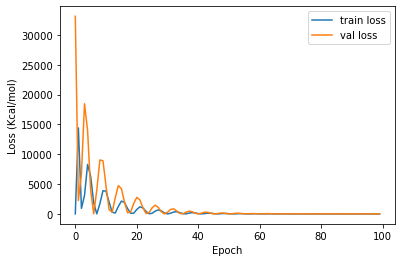

In [29]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(sahar_pgnn_losses)), sahar_pgnn_losses, label='train loss')
plt.plot(range(len(sahar_pgnn_val_losses)), sahar_pgnn_val_losses, label='val loss')
plt.legend(loc='upper right')
# plt.ylim(0,500)
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.savefig('Sahar_PGNN_loss_26Mar.png')

In [30]:
hybrid_model.input_shapes = [i.shape for i in x_preprocessed_test]
hybrid_model.modify_graphgather(len(y_test))

In [31]:
evalu = hybrid_model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 3s 3s/step - loss: 20.1714


In [32]:
# Calculate RMSE
sahar_pgnn_rmse_test = np.sqrt(evalu)
print(sahar_pgnn_rmse_test)

4.491253087260085


In [159]:
# Average training loss
# sahar_train_loss = [sum(x)/len(x) for x in zip(*sahar_pgnn_losses)]
sahar_train_loss = sahar_pgnn_losses[-1]

In [160]:
sahar_train_loss

[13.601899147033691]

In [204]:
# Calculate RMSE
import math
sahar_pgnn_rmse_train = math.sqrt(sahar_train_loss[0])
sahar_pgnn_rmse_train

3.6880752632008056

In [205]:
sahar_pgnn_rmse_test

4.491253087260085

# Physics based model RMSE

In [38]:
# import math
# train_sum=0
# for i in range(len(host_names_train)):
#     new_df = df[(df['complex-name'] == host_names_train[i])]
#     train_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2


# test_sum = 0
# for i in range(len(host_names_test)):
#     new_df = df[(df['complex-name'] == host_names_test[i])]
#     test_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2
    

In [39]:
# physics_based_rmse_train = math.sqrt(train_sum / len(host_names_train))

In [40]:
# physics_based_rmse_test = math.sqrt((test_sum) / len(host_names_test))

In [41]:
# print(f"RMSE on training set is : {physics_based_rmse_train}")
# print(f"RMSE on testing set is : {physics_based_rmse_test}")
# # Total rmse
# total_rmse_physics = np.sqrt(np.mean((df['EX _H_(kcal/mol)'].to_numpy() - df['gb_delta_H'].to_numpy())**2))
# print(f"RMSE of the total data: {total_rmse_physics}")

In [42]:
# # RMSE gbnsr6 vs experimental
# from sklearn.metrics import mean_squared_error
# import math
# mse_gb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['gb_delta_H'])
# rmse_gbnsr6_ex = math.sqrt(mse_gb_ex)
# print(rmse_gbnsr6_ex)

In [43]:
# # RMSE pbsa vs experimental
# mse_pb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['pb_delta_H'])
# rmse_pbsa_ex = math.sqrt(mse_pb_ex)
# print(rmse_pbsa_ex)

In [44]:
# # RMSE gbnsr6 vs pbsa
# mse_gb_pb = mean_squared_error(df['pb_delta_H'], df['gb_delta_H'])
# rmse_gb_pb = math.sqrt(mse_gb_pb)
# print(rmse_gb_pb)

In [45]:
# import matplotlib.pyplot as plt

# plt.title("Experimental vs GBNSR6")
# plt.scatter(x=df['EX _H_(kcal/mol)'], y=df['gb_delta_H'])
# plt.xlabel("Experimental Delta H")
# plt.ylabel("GBNSR6 Delta H")
# plt.xlim(-25, 5)
# plt.ylim(-25,5)

# #reference line
# plt.plot([-25, 5], [-25, 5], color='green', lw=1)

In [46]:
# plt.title("Experimental vs PBSA")
# plt.scatter(x=df['EX _H_(kcal/mol)'] ,y=df['pb_delta_H'], color='orange')
# plt.xlabel("Experimental Delta H")
# plt.ylabel("PBSA Delta H")
# plt.xlim(-25, 5)
# plt.ylim(-25,5)
# #reference line
# plt.plot([-25,5],[-25,5], color='green')

In [47]:
# ax = plt.subplot()
# # plt.title("PBSA vs GBNSR6")
# plt.xlabel('Experimental ∆H (kcal/mol)')
# plt.ylabel('Physics-based model ∆H (kcal/mol)')
# ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['gb_delta_H'], label="GBNSR6")
# ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['pb_delta_H'], label="PBSA", color="orange")
# plt.xlim(-25,5)
# plt.ylim(-25,5)
# #reference line
# plt.plot([-25,5],[-25,5],color='green')
# plt.legend()
# plt.savefig('gb-pb.png')

In [48]:
# gb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['EX _H_(kcal/mol)'])
# gb_correlation_gbex = gb_correlation_matrix[0,1]
# gb_r_squared = gb_correlation_gbex**2
# print(gb_r_squared)

In [49]:
# pb_correlation_matrix = np.corrcoef(df['pb_delta_H'], df['EX _H_(kcal/mol)'])
# pb_correlation_pbex = pb_correlation_matrix[0,1]
# pb_r_squared = pb_correlation_pbex**2
# print(pb_r_squared)

In [50]:
# pbgb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['pb_delta_H'])
# pbgb_correlation = pbgb_correlation_matrix[0,1]
# pbgb_r_squared = pbgb_correlation**2
# print(pbgb_r_squared)

<h1> Data Driven Model </h1>

In [51]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
input_shapes = [i.shape for i in x_preprocessed_train]

In [52]:
sahar_dd_test_accuracy = []
sahar_dd_train_accuracy = []

In [53]:
batch_size = int(len(pdb_names_train)/4)
batch_size
# batch_size=10

24

In [54]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class GBGraphConvModel(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(GBGraphConvModel, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(1)
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)
sahar_dd_model = GBGraphConvModel(train_split_index)
sahar_dd_model.compile(loss='mse', optimizer="adam")

In [55]:
sahar_dd_losses, sahar_dd_val_losses = [], []

val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    sahar_dd_model.modify_graphgather(train_size)
    sahar_dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
    dd_loss = sahar_dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    sahar_dd_losses.append(dd_loss.history['loss'])
    sahar_dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
    sahar_dd_model.modify_graphgather(val_size)
    sahar_dd_val_losses.append(sahar_dd_model.evaluate(x_val, y_val.reshape([1, -1])))

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_14:0", shape=(83387,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_13:0", shape=(83387, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_17:0", shape=(205678,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/

1/1 [==============================] - 4s 4s/step - loss: 8.9737


1/1 [==============================] - 1s 1s/step - loss: 71.3899


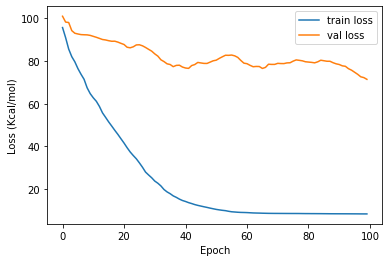

In [56]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(sahar_dd_losses)), sahar_dd_losses, label='train loss')
plt.plot(range(len(sahar_dd_val_losses)), sahar_dd_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.savefig('Sahar_DataDriven_loss_26Mar.png')

In [57]:
sahar_dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
sahar_dd_model.modify_graphgather(len(y_test))
sahar_dd_test_loss= sahar_dd_model.evaluate(x_test, y_test.reshape([1, -1]))
# test_pgnn_loss = dd_model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 1s 957ms/step - loss: 71.3899


In [58]:
sahar_dd_rmse_test = np.sqrt(sahar_dd_test_loss)
print(sahar_dd_rmse_test)

8.449255320222521


In [110]:
# sahar_dd_train_loss = sahar_dd_losses[-1]
# sahar_dd_train_loss

In [164]:
# Average training loss
# sahar_dd_train_loss = [sum(x)/len(x) for x in zip(*sahar_dd_losses)]
sahar_dd_train_loss = sahar_dd_losses[-1]
sahar_dd_train_loss

[8.43713665008545]

In [165]:
import math
sahar_dd_rmse_train = math.sqrt(sahar_dd_train_loss[0])
# train_dd_rmse = math.sqrt(dd_train_loss[0])
sahar_dd_rmse_train

2.9046749646191827

In [166]:
sahar_dd_test_accuracy = sahar_dd_rmse_test
sahar_dd_train_accuracy = sahar_dd_rmse_train

In [167]:
print(sahar_dd_test_accuracy)

8.449255320222521


In [168]:
sahar_dd_train_accuracy

2.9046749646191827

<h1> Model Comparisons </h1>

In [115]:
# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Sahar's model Test Set RMSE"
rmse_table.field_names = [ "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(sahar_dd_rmse_test),"{:.2f}".format(sahar_pgnn_rmse_test)])
print(rmse_table)

+----------------------------+
| Sahar's model Test Set RMSE |
+-------------------+--------+
|    Data Driven    |  PGNN  |
+-------------------+--------+
|        8.45       |  4.49  |
+-------------------+--------+


In [66]:
# results_df = pd.DataFrame(np.array([sahar_dd_rmse_test,sahar_pgnn_rmse_test,sahar_dd_rmse_train,sahar_pgnn_rmse_train]).reshape(-1, 4),columns=['test-data-driven-rmse', 'test-pgnn-rmse', 'train-data-driven-rmse','train-pgnn-rmse'])

In [116]:
# Train
rmse_table = PrettyTable()
rmse_table.title="Train Set RMSE"
rmse_table.field_names = ["Data Driven", "PGNN"]
rmse_table.add_row([ "{:.2f}".format(sahar_dd_rmse_train),"{:.2f}".format(sahar_pgnn_rmse_train)])
print(rmse_table)

+---------------------+
|    Train Set RMSE   |
+-------------+-------+
| Data Driven |  PGNN |
+-------------+-------+
|     4.90    | 24.93 |
+-------------+-------+


<h1> PGNN and DD model average performance analysis </h1>

In [ ]:
# train_results_dict = {
#     "pgnn_train" : [x for x in pgnn_train_accuracy],
#     "dd_train" : [x for x in dd_train_accuracy]
# }
# test_results_dict ={
#     "pgnn_test" : [x for x in pgnn_test_accuracy],
#     "dd_test" : [x for x in dd_test_accuracy]
# }

In [ ]:
# import matplotlib.pyplot as plt
# # Train box plot
# plt.figure(figsize=(10,12))
# plt.title("Train RMSE comparison")
# plt.boxplot([x for x in train_results_dict.values()],labels=[x for x in train_results_dict.keys()])
# plt.xlabel("PGNN and DD train")
# plt.ylabel("RMSE")
# plt.ylim(2, 5, 0.3)


In [ ]:
# import matplotlib.pyplot as plt
# # Test box plot
# plt.figure(figsize=(10,12))
# plt.title("Test RMSE comparison")
# plt.boxplot([x for x in test_results_dict.values()],labels=[x for x in test_results_dict.keys()])
# plt.xlabel("PGNN and DD train")
# plt.ylabel("RMSE")
# plt.ylim(0, 8, 0.3)



<h1> Ali's version</h1>

In [68]:
training_columns = [col for col in df.columns if (col[:3] == 'gb-' and not col.__contains__('etot')) or (col.__contains__('vdwaals'))]

In [69]:
df['gb-overall-1-4-eel'] = df.apply(lambda row: row['gb-complex-1-4-eel'] - row['gb-protein-1-4-eel'] - row['gb-ligand-1-4-eel'], axis=1)
df['gb-overall-eelec'] = df.apply(lambda row: row['gb-complex-eelec'] - row['gb-protein-eelect'] - row['gb-ligand-eelec'], axis=1)
df['gb-overall-egb'] = df.apply(lambda row: row['gb-complex-egb'] - row['gb-protein-egb'] - row['gb-ligand-egb'], axis=1)
df['gb-overall-esurf'] = df.apply(lambda row: row['gb-complex-esurf'] - row['gb-protein-esurf'] - row['gb-ligand-esurf'], axis=1)
df['pb-overall-vdwaals'] = df.apply(lambda row: row['pb-complex-vdwaals'] - row['pb-protein-vdwaals'] - row['pb-ligand-vdwaals'], axis=1)

In [70]:
a = df['gb-overall-eelec'].to_numpy()

<AxesSubplot:xlabel='pb-overall-vdwaals', ylabel='Frequency'>

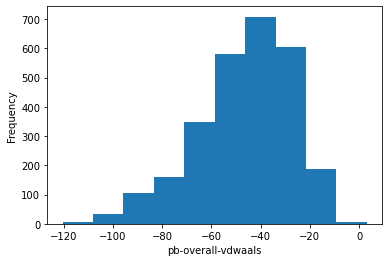

In [71]:
import matplotlib.pyplot as plt
plt.xlabel('pb-overall-vdwaals')
df['pb-overall-vdwaals'].plot.hist()

In [72]:
training_columns = [f for f in df.columns if f.__contains__('overall')]

<AxesSubplot:xlabel='gb-overall-eelec', ylabel='Frequency'>

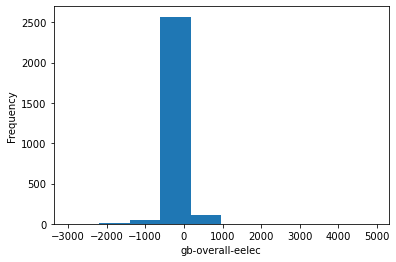

In [73]:
plt.xlabel('gb-overall-eelec')
df['gb-overall-eelec'].plot.hist()

<AxesSubplot:xlabel='gb-overall-eelec normalized', ylabel='Frequency'>

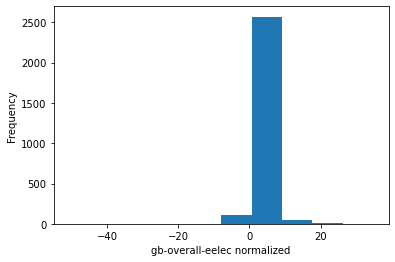

In [74]:
plt.xlabel('gb-overall-eelec normalized')
((df['gb-overall-eelec'] - df['gb-overall-eelec'].std()) / df['gb-overall-eelec'].mean()).plot.hist()

In [75]:
# ## Save PDB
# import pickle
# with open('PDBs.pkl', 'wb') as file:
#     pickle.dump(PDBs, file)

In [76]:
## Load PDB
# import pickle
# PDBs = {}
# with open('PDBs.pkl', 'rb') as file:
#     PDBs = pickle.load(file)

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[training_columns]),
                   columns=training_columns)

<AxesSubplot:xlabel='gb-overall-1-4-eel', ylabel='Frequency'>

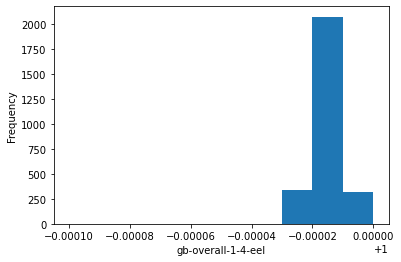

In [78]:
plt.xlabel('gb-overall-1-4-eel')
df_scaled['gb-overall-1-4-eel'].plot.hist(range=[0.9999, 1.0])

In [79]:
# SC: not required. Done once above.
# X = []
# X_ids = []
# # one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
# for k in PDBs.keys():
#     X_ids.append(k)
#     X.append(featurizer.featurize(PDBs[k]))
# split_index = int(len(X) * TRAIN_SET)
# X = [x[0] for x in X]
# X_train_featurized = X[:split_index]
# X_test_featurized = X[split_index:]

In [80]:
# pdb_names = [i for i in X_ids]
# pdb_names_train = pdb_names[:train_split_index]
# pdb_names_test = pdb_names[split_index:]

In [81]:
# x_add_train, x_add_test, y_train, y_test = [], [], [], []
# for i in range(len(pdb_names_train)):
#     new_df = df[(df['complex-name'] == pdb_names_train[i])]
#     y_train.append(new_df['ddg'].to_numpy()[0])
#     x_add_train.append(-new_df[training_columns].to_numpy()[0])
# y_train = np.array(y_train)
    
# for i in range(len(pdb_names_test)):
#     new_df = df[(df['complex-name'] == pdb_names_test[i])]
# #     print(pdb_names_test[i])
# #     print(new_df['ddg'].to_numpy())
#     y_test.append(new_df['ddg'].to_numpy()[0])
#     x_add_test.append(-new_df[training_columns].to_numpy()[0])
# y_test = np.array(y_test)

In [85]:
x_add_train,x_add_val, x_add_test, y_train,y_val, y_test = [], [], [], [], [], []
# Train
for i in range(len(pdb_names_train)):
    new_df = df[(df['complex-name'] == pdb_names_train[i])]
    y_train.append(new_df['ddg'].to_numpy()[0])
    x_add_train.append(-new_df[training_columns].to_numpy()[0])
y_train = np.array(y_train)

# Val
for i in range(len(pdb_names_val)):
    new_df = df[(df['complex-name'] == pdb_names_val[i])]
    y_val.append(new_df['ddg'].to_numpy()[0])
    x_add_val.append(-new_df[training_columns].to_numpy()[0])
y_val = np.array(y_val)


# Test
for i in range(len(pdb_names_test)):
    new_df = df[(df['complex-name'] == pdb_names_test[i])]
#     print(pdb_names_test[i])
#     print(new_df['ddg'].to_numpy())
    y_test.append(new_df['ddg'].to_numpy()[0])
    x_add_test.append(-new_df[training_columns].to_numpy()[0])
y_test = np.array(y_test)

In [86]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_test = [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X val
multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_val.append(np.array(x_add_val))

## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [87]:
# Training
x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

# Validation
x_val = np.full([14, np.max([v.shape[0] for v in x_preprocessed_val]),
                  np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_val):
    if len(j.shape) > 1:
        x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_val = x_val.reshape([1] + list(x_val.shape))

# Testing

x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

# Ali's PGNN Model - 5 parameters

In [88]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class PGNNAli(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(PGNNAli, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
    self.dense4 = layers.Dense(1, 
     kernel_initializer=initializers.Constant([.5, 1, 1, 1, 1, 1]),
     bias_initializer=initializers.Zeros())
#     self.dense4 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
#          bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 5])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    ddg = self.dense4(binding_affinity)
    tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
    tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
    tf.print(ddg[0], output_stream="file://ddg.txt")
    tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
    tf.print("-------------------------", output_stream=sys.stdout)
    return ddg

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
ali_pgnn_model = PGNNAli(train_split_index)
ali_pgnn_model.compile(optimizer = "rmsprop", loss = root_mean_squared_error)
K.set_value(ali_pgnn_model.optimizer.learning_rate, 0.001)

In [ ]:
# model.input_shapes = [i.shape for i in x_preprocessed_train]
# history = model.fit(x_train, -y_train.reshape([1, -1]), epochs=3)

In [90]:
ali_pgnn_losses, ali_pgnn_val_losses = [], []
val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    ali_pgnn_model.modify_graphgather(train_size)
    ali_pgnn_model.input_shapes = [i.shape for i in x_preprocessed_train]
    ali_loss = ali_pgnn_model.fit(x_train, -y_train.reshape([1, -1]), epochs=1)
#     history = model.fit(x_train, -y_train.reshape([1, -1]), epochs=3)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    ali_pgnn_losses.append(ali_loss.history['loss'])
    ali_pgnn_model.input_shapes = [i.shape for i in x_preprocessed_val]
    ali_pgnn_model.modify_graphgather(val_size)
    ali_pgnn_val_losses.append(ali_pgnn_model.evaluate(x_val, y_val.reshape([1, -1])))

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_ali/graph_pool_5/Reshape_14:0", shape=(83387,), dtype=int32), values=Tensor("gradient_tape/pgnn_ali/graph_pool_5/Reshape_13:0", shape=(83387, 64), dtype=float32), dense_shape=Tensor("gradient_tape/pgnn_ali/graph_pool_5/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_ali/graph_pool_5/Reshape_17:0", shape=(205678,), dtype=int32), values=Tensor("gradient_tape/pgnn_ali/graph_pool_5/Reshape_16:0", shape=(205678, 64), dtype=float32), dense_shape=Te

-------------------------
1/1 [==============================] - 15s 15s/step - loss: 45.3552
-------------------------
1/1 [==============================] - 3s 3s/step - loss: 44.6002
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 45.0083
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 44.5184
-------------------------
1/1 [==============================] - 6s 6s/step - loss: 44.7851
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 44.4623
-------------------------
1/1 [==============================] - 6s 6s/step - loss: 44.6294
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 44.4048
-------------------------
1/1 [==============================] - 4s 4s/step - loss: 44.5190
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 44.3554
-------------------------
1/1 [==============================] - 5s 5s/step - 

1/1 [==============================] - 1s 1s/step - loss: 42.8274
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 40.9832
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 42.7755
-------------------------
1/1 [==============================] - 6s 6s/step - loss: 40.8999
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 42.7679
-------------------------
1/1 [==============================] - 4s 4s/step - loss: 40.8314
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 42.7681
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 40.7505
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 42.7587
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 40.6763
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 42.7224
--------------

1/1 [==============================] - 5s 5s/step - loss: 37.9270
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 41.0022
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 37.8639
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 40.9116
-------------------------
1/1 [==============================] - 4s 4s/step - loss: 37.7996
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 40.8915
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 37.7246
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 40.8072
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 37.6824
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 40.8308
-------------------------
1/1 [==============================] - 5s 5s/step - loss: 37.6193
--------------

In [91]:
# chekcing the wights after training
ali_pgnn_model.layers[-1].get_weights()

[array([[0.6208926],
        [1.1067361],
        [0.8925526],
        [0.9125809],
        [1.1033266],
        [1.0196115]], dtype=float32),
 array([0.1054638], dtype=float32)]

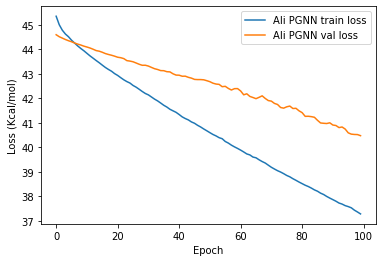

In [92]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(ali_pgnn_losses)), ali_pgnn_losses, label='Ali PGNN train loss')
plt.plot(range(len(ali_pgnn_val_losses)), ali_pgnn_val_losses, label='Ali PGNN val loss')
plt.legend(loc='upper right')
# plt.ylim(0,500)
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.savefig('Ali_PGNN_loss_26Mar.png')

In [93]:
ali_pgnn_model.input_shapes = [i.shape for i in x_preprocessed_test]
ali_pgnn_model.modify_graphgather(len(y_test))
ali_pgnn_test_loss= ali_pgnn_model.evaluate(x_test, y_test.reshape([1, -1]))
# test_pgnn_loss = dd_model.evaluate(x_test, y_test.reshape([1, -1]))


-------------------------
1/1 [==============================] - 1s 1s/step - loss: 40.4770


In [197]:
ali_pgnn_rmse_test = ali_pgnn_test_loss

In [198]:
ali_pgnn_rmse_test

40.47704315185547

In [199]:

ali_pgnn_rmse_train = ali_pgnn_losses[-1]
# ali_pgnn_train_loss = [sum(x)/len(x) for x in zip(*ali_pgnn_losses)]
# ali_pgnn_rmse_train = math.sqrt(ali_pgnn_rmse_train[0])

In [200]:
ali_pgnn_rmse_train

[37.28062438964844]

In [123]:

ali_pgnn_test_accuracy = ali_pgnn_rmse_test
ali_pgnn_train_accuracy = ali_pgnn_rmse_train



# Ali DataDriven Model

In [94]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class GBGraphConvModelAli(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(GBGraphConvModelAli, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
    self.dense4 = layers.Dense(1) 
#      kernel_initializer=initializers.Constant([.5, 1, 1, 1, 1, 1]),
#      bias_initializer=initializers.Zeros())
#     self.dense4 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
#          bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 5])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
#     binding_affinity = tf.concat([model_var, x_add], axis=1)
#     ddg = self.dense4(binding_affinity)
#     tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
#     tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
#     tf.print(ddg[0], output_stream="file://ddg.txt")
#     tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
#     tf.print("-------------------------", output_stream=sys.stdout)
    return model_var

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true))) 
ali_dd_model = GBGraphConvModelAli(train_split_index)
ali_dd_model.compile(optimizer = "rmsprop", loss = 'mse')
K.set_value(ali_dd_model.optimizer.learning_rate, 0.001)

In [95]:
ali_dd_losses, ali_dd_val_losses = [], []
val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    ali_dd_model.modify_graphgather(train_size)
    ali_dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
    ali_dd_loss = ali_dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#     history = model.fit(x_train, -y_train.reshape([1, -1]), epochs=3)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    ali_dd_losses.append(ali_dd_loss.history['loss'])
    ali_dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
    ali_dd_model.modify_graphgather(val_size)
    ali_dd_val_losses.append(ali_dd_model.evaluate(x_val, y_val.reshape([1, -1])))

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_ali/graph_pool_7/Reshape_14:0", shape=(83387,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_ali/graph_pool_7/Reshape_13:0", shape=(83387, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_ali/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_ali/graph_pool_7/Reshape_17:0", shape=(205678,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_ali/gra

1/1 [==============================] - 1s 1s/step - loss: 19.6740


1/1 [==============================] - 1s 1s/step - loss: 10.5396


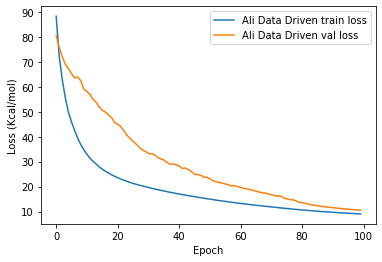

In [96]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(ali_dd_losses)), ali_dd_losses, label='Ali Data Driven train loss')
plt.plot(range(len(ali_dd_val_losses)), ali_dd_val_losses, label='Ali Data Driven val loss')
plt.legend(loc='upper right')
# plt.ylim(0,500)
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.savefig('Ali_DD_loss_26Mar.png')

In [97]:
ali_dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
ali_dd_model.modify_graphgather(len(y_test))
ali_dd_test_loss = ali_dd_model.evaluate(x_test, y_test.reshape([1, -1]))
# calculate RMSE
# ali_dd_rmse_test = np.sqrt(ali_dd_test_loss)


1/1 [==============================] - 1s 1s/step - loss: 10.5396


In [192]:
ali_dd_rmse_test = ali_dd_test_loss 

In [194]:
# Average training loss
# ali_dd_rmse_loss = [sum(x)/len(x) for x in zip(*ali_dd_losses)]
ali_dd_rmse_loss = ali_dd_losses[-1]
# ali_dd_rmse_train = math.sqrt(ali_dd_test_loss)
ali_dd_rmse_train = ali_dd_rmse_loss

In [195]:
ali_dd_rmse_train

[9.05095386505127]

In [125]:
# ali_dd_test_accuracy = ali_dd_rmse_test
# ali_dd_train_accuracy = ali_dd_rmse_train

In [191]:
ali_dd_rmse_test

3.246477712606718

In [126]:
# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Ali's model Test Set RMSE"
rmse_table.field_names = [ "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(ali_dd_rmse_test),"{:.2f}".format(ali_pgnn_rmse_test)])
print(rmse_table)

+---------------------------+
| Ali's model Test Set RMSE |
+------------------+--------+
|   Data Driven    |  PGNN  |
+------------------+--------+
|       3.25       |  6.36  |
+------------------+--------+


In [140]:
ali_pgnn_rmse_train

[40.78380676269531]

In [144]:
# Train
rmse_table = PrettyTable()
rmse_table.title="Ali's model Train Set RMSE"
rmse_table.field_names = ["Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(ali_dd_rmse_train[0]),"{:.2f}".format(ali_pgnn_rmse_train[0])])
print(rmse_table)

+---------------------------+
| Ali's model Train Set RMSE |
+-----------------+---------+
|   Data Driven   |   PGNN  |
+-----------------+---------+
|      19.44      |  40.78  |
+-----------------+---------+


# Comparison All Models

In [202]:
# Train
rmse_table = PrettyTable()
rmse_table.title="All Models Comparison Training Set"
rmse_table.field_names = ["Sahar Data Driven", "Sahar PGNN", "Ali Data Driven", "Ali PGNN"]
rmse_table.add_row([ "{:.2f}".format(sahar_dd_rmse_train),"{:.2f}".format(sahar_pgnn_rmse_train),
                    "{:.2f}".format(ali_dd_rmse_train[0]),"{:.2f}".format(ali_pgnn_rmse_train[0])])

print(rmse_table)

+-------------------------------------------------------------+
|              All Models Comparison Training Set             |
+-------------------+------------+-----------------+----------+
| Sahar Data Driven | Sahar PGNN | Ali Data Driven | Ali PGNN |
+-------------------+------------+-----------------+----------+
|        2.90       |    3.69    |       9.05      |  37.28   |
+-------------------+------------+-----------------+----------+


In [203]:
# Train
rmse_table = PrettyTable()
rmse_table.title="All Models Comparison Testing Set"
rmse_table.field_names = ["Sahar Data Driven", "Sahar PGNN", "Ali Data Driven", "Ali PGNN"]
rmse_table.add_row([ "{:.2f}".format(sahar_dd_rmse_test),"{:.2f}".format(sahar_pgnn_rmse_test),
                    "{:.2f}".format(ali_dd_rmse_test),"{:.2f}".format(ali_pgnn_rmse_test)])
print(rmse_table)

+-------------------------------------------------------------+
|              All Models Comparison Testing Set              |
+-------------------+------------+-----------------+----------+
| Sahar Data Driven | Sahar PGNN | Ali Data Driven | Ali PGNN |
+-------------------+------------+-----------------+----------+
|        8.45       |    4.49    |      10.54      |  40.48   |
+-------------------+------------+-----------------+----------+
